<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Modelo de lenguaje con tokenización por caracteres

In [2]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Datos
Utilizaremos como dataset noticias en inglés del archivo news.csv, combinando los campos title y text.

In [4]:
# Load news dataset
news_df = pd.read_csv('news.csv')

print(f"Dataset shape: {news_df.shape}")
print(f"Columns: {news_df.columns.tolist()}")
print(f"Subjects: {news_df['subject'].unique()}")

# Combine title and text columns
news_df['combined_text'] = news_df['title'] + '. ' + news_df['text']

# Create the article_text by concatenating all news articles
article_text = ' '.join(news_df[:35]['combined_text'].astype(str))

# pasar todo el texto a minúscula
article_text = article_text.lower()

print(f"Total text length before cleaning: {len(article_text)} characters")

Dataset shape: (21417, 4)
Columns: ['title', 'text', 'subject', 'date']
Subjects: ['politicsNews' 'worldnews']
Total text length before cleaning: 91842 characters


In [5]:
import re

# Limpiar texto
def clean_text(text):
    cleaned = re.sub(r'[^\w\s.,!?;:\-\'áéíóúñçàèìòùâêîôûäëïöü]', ' ', text, flags=re.UNICODE)
    cleaned = re.sub(r'\s+', ' ', cleaned).strip()
    return cleaned

article_text = clean_text(article_text)
print(f"Cleaned text length: {len(article_text)} characters")
print(f"Sample: {article_text[:200]}...")

Cleaned text length: 91094 characters
Sample: as u.s. budget fight looms, republicans flip their fiscal script. washington reuters - the head of a conservative republican faction in the u.s. congress, who voted this month for a huge expansion of ...


In [6]:
# en article text se encuentra el texto completo
article_text[:1000]

'as u.s. budget fight looms, republicans flip their fiscal script. washington reuters - the head of a conservative republican faction in the u.s. congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a fiscal conservative on sunday and urged budget restraint in 2018. in keeping with a sharp pivot under way among republicans, u.s. representative mark meadows, speaking on cbs face the nation, drew a hard line on federal spending, which lawmakers are bracing to do battle over in january. when they return from the holidays on wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the november congressional election campaigns approach in which republicans will seek to keep control of congress. president donald trump and his republicans want a big budget increase in military spending, while democrats also want proportional increases for non-defen

### Elegir el tamaño del contexto

En este caso, como el modelo de lenguaje es por caracteres, todo un gran corpus
de texto puede ser considerado un documento en sí mismo y el tamaño de contexto
puede ser elegido con más libertad en comparación a un modelo de lenguaje tokenizado por palabras y dividido en documentos más acotados.

In [7]:
# seleccionamos el tamaño de contexto
max_context_size = 250

In [8]:
# Usaremos las utilidades de procesamiento de textos y secuencias de Keras
from tensorflow.keras.utils import pad_sequences # se utilizará para padding

In [9]:
# en este caso el vocabulario es el conjunto único de caracteres que existe en todo el texto
chars_vocab = set(article_text)

In [10]:
# la longitud de vocabulario de caracteres es:
len(chars_vocab)

44

In [11]:
# Construimos los dicionarios que asignan índices a caracteres y viceversa.
# El diccionario `char2idx` servirá como tokenizador.
char2idx = {k: v for v,k in enumerate(chars_vocab)}
idx2char = {v: k for k,v in char2idx.items()}

###  Tokenizar

In [12]:
# tokenizamos el texto completo
tokenized_text = [char2idx[ch] for ch in article_text]

In [13]:
tokenized_text[:10]

[34, 7, 4, 27, 31, 7, 31, 4, 11, 27]

### Organizando y estructurando el dataset

In [14]:
# separaremos el dataset entre entrenamiento y validación.
# `p_val` será la proporción del corpus que se reservará para validación
# `num_val` es la cantidad de secuencias de tamaño `max_context_size` que se usará en validación
p_val = 0.1
num_val = int(np.ceil(len(tokenized_text)*p_val/max_context_size))

In [15]:
# separamos la porción de texto utilizada en entrenamiento de la de validación.
train_text = tokenized_text[:-num_val*max_context_size]
val_text = tokenized_text[-num_val*max_context_size:]

In [16]:
tokenized_sentences_val = [val_text[init*max_context_size:init*(max_context_size+1)] for init in range(num_val)]

In [17]:
tokenized_sentences_train = [train_text[init:init+max_context_size] for init in range(len(train_text)-max_context_size+1)]

In [18]:
X = np.array(tokenized_sentences_train[:-1])
y = np.array(tokenized_sentences_train[1:])

Nótese que estamos estructurando el problema de aprendizaje como *many-to-many*:

Entrada: secuencia de tokens [$x_0$, $x_1$, ..., $x_N$]

Target: secuencia de tokens [$x_1$, $x_2$, ..., $x_{N+1}$]

De manera que la red tiene que aprender que su salida deben ser los tokens desplazados en una posición y un nuevo token predicho (el N+1).

La ventaja de estructurar el aprendizaje de esta manera es que para cada token de target se propaga una señal de gradiente por el grafo de cómputo recurrente, que es mejor que estructurar el problema como *many-to-one* en donde sólo una señal de gradiente se propaga.

En este punto tenemos en la variable `tokenized_sentences` los versos tokenizados. Vamos a quedarnos con un conjunto de validación que utilizaremos para medir la calidad de la generación de secuencias con la métrica de Perplejidad.

## Comparando diferentes arquitecturas RNN

Según la consigna, exploraremos SimpleRNN, LSTM y GRU para implementar el modelo de lenguaje.

In [19]:
from keras.layers import LSTM, GRU, Input, TimeDistributed, CategoryEncoding, SimpleRNN, Dense
from keras.models import Sequential

def create_model(rnn_type='SimpleRNN', units=200, vocab_size=len(chars_vocab)):
    """
    Crear modelo RNN con diferentes arquitecturas

    Args:
        rnn_type: 'SimpleRNN', 'LSTM', or 'GRU'
        units: number of RNN units
        vocab_size: vocabulary size
    """
    model = Sequential()

    model.add(TimeDistributed(CategoryEncoding(num_tokens=len(chars_vocab), output_mode="one_hot"),
                             input_shape=(None, 1)))

    if rnn_type == 'SimpleRNN':
        model.add(SimpleRNN(units, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))
    elif rnn_type == 'LSTM':
        model.add(LSTM(units, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))
    elif rnn_type == 'GRU':
        model.add(GRU(units, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))
    else:
        raise ValueError("rnn_type tiene que ser 'SimpleRNN', 'LSTM' o 'GRU'")

    model.add(Dense(len(chars_vocab), activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

    return model

# Crear modelos
models = {}
for rnn_type in ['SimpleRNN', 'LSTM', 'GRU']:
    print(f"\n=== Creando modelo {rnn_type} ===")
    models[rnn_type] = create_model(rnn_type, units=200, vocab_size=len(chars_vocab))
    models[rnn_type].summary()


=== Creando modelo SimpleRNN ===


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, None, 44)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, None, 200)      │        49,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, None, 44)       │         8,844 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,844 (225.95 KB)

 Trainable params: 57,844 (225.95 KB)

 Non-trainable params: 0 (0.00 B)


=== Creando modelo LSTM ===


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_1              │ (None, None, 44)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, None, 200)      │       196,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, None, 44)       │         8,844 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 204,844 (800.17 KB)

 Trainable params: 204,844 (800.17 KB)

 Non-trainable params: 0 (0.00 B)


=== Creando modelo GRU ===


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_2              │ (None, None, 44)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, None, 200)      │       147,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, None, 44)       │         8,844 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 156,444 (611.11 KB)

 Trainable params: 156,444 (611.11 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl,patience=5):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad
      self.val_data = val_data

      self.target = []
      self.padded = []

      count = 0
      self.info = []
      self.min_score = np.inf
      self.patience_counter = 0
      self.patience = patience

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(1,len_seq)]
        self.target.extend([seq[i] for i in range(1,len_seq)])

        if len(subseq)!=0:

          self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

          self.info.append((count,count+len_seq))
          count += len_seq

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

        # para cada secuencia de validación
        for start,end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,-1,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        current_score = np.mean(scores)
        history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        # chequeamos si tenemos que detener el entrenamiento
        if current_score < self.min_score:
          self.min_score = current_score
          self.model.save("my_model.keras")
          print("Saved new model!")
          self.patience_counter = 0
        else:
          self.patience_counter += 1
          if self.patience_counter == self.patience:
            print("Stopping training...")
            self.model.stop_training = True


In [26]:
selected_model = 'LSTM'

print(f"Training {selected_model} model...")
model = models[selected_model]

# Entrenar el modelo
history_ppl = []
hist = model.fit(X, y, epochs=10,
                callbacks=[PplCallback(tokenized_sentences_val, history_ppl)],
                batch_size=256)

Training LSTM model...
Epoch 1/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 645ms/step - loss: 2.9694
 mean perplexity: 12.690791130065918 

Saved new model!
319/319 ━━━━━━━━━━━━━━━━━━━━ 229s 675ms/step - loss: 2.9688
Epoch 2/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 635ms/step - loss: 2.4266
 mean perplexity: 11.181818008422852 

Saved new model!
319/319 ━━━━━━━━━━━━━━━━━━━━ 206s 646ms/step - loss: 2.4265
Epoch 3/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 640ms/step - loss: 2.2630
 mean perplexity: 10.363110542297363 

Saved new model!
319/319 ━━━━━━━━━━━━━━━━━━━━ 208s 651ms/step - loss: 2.2629
Epoch 4/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 642ms/step - loss: 2.1482
 mean perplexity: 9.822965621948242 

Saved new model!
319/319 ━━━━━━━━━━━━━━━━━━━━ 208s 653ms/step - loss: 2.1482
Epoch 5/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 642ms/step - loss: 2.0620
 mean perplexity: 9.45362663269043 

Saved new model!
319/319 ━━━━━━━━━━━━━━━━━━━━ 208s 653ms/step - loss: 2.0620
Epoch 6/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 639ms/step -

### Entrenamiento

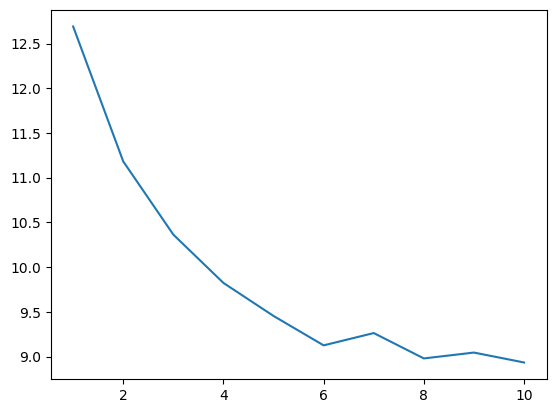

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()

### Generación de secuencias

In [28]:
def generate_seq(model, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de caracteres a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = [char2idx[ch] for ch in output_text.lower() ]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		# Predicción softmax
        y_hat = np.argmax(model.predict(encoded,verbose=0)[0,-1,:])
		# Vamos concatenando las predicciones
        out_word = ''

        out_word = idx2char[y_hat]

		# Agrego las palabras a la frase predicha
        output_text += out_word
    return output_text

In [29]:
input_text='the congress'

generate_seq(model, input_text, max_length=max_context_size, n_words=30)

'the congress and the past of the past of t'

###  Beam search y muestreo aleatorio

In [30]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=max_context_size):

    encoded = [char2idx[ch] for ch in text]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return ''.join([idx2char[ch] for ch in seq])

In [31]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens[:,-(len(input)+num_words):]

### Generación de secuencias

Implementaremos las estrategias solicitadas:
1. **Greedy search**: Selecciona siempre el token más probable
2. **Beam search determinístico**: Mantiene los k mejores candidatos
3. **Beam search estocástico**: Muestreo aleatorio con temperatura

In [32]:
def generate_seq_greedy(model, seed_text, max_length, n_chars):
    """
    Greedy search: always select the most probable next character
    """
    output_text = seed_text
    for _ in range(n_chars):
        encoded = [char2idx[ch] for ch in output_text.lower()]
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

        # Greedy: select most probable character
        y_hat = np.argmax(model.predict(encoded, verbose=0)[0, -1, :])
        output_text += idx2char[y_hat]

    return output_text

def generate_seq_stochastic(model, seed_text, max_length, n_chars, temperature=1.0):
    """
    Stochastic sampling with temperature
    """
    output_text = seed_text
    for _ in range(n_chars):
        encoded = [char2idx[ch] for ch in output_text.lower()]
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

        # Get probabilities and apply temperature
        probs = model.predict(encoded, verbose=0)[0, -1, :]
        probs = np.exp(np.log(probs + 1e-10) / temperature)
        probs = probs / np.sum(probs)

        # Sample from the distribution
        y_hat = np.random.choice(len(probs), p=probs)
        output_text += idx2char[y_hat]

    return output_text

In [33]:
# Test different generation strategies
seed_text = "the president"
n_chars = 100

print("=== GREEDY SEARCH ===")
greedy_result = generate_seq_greedy(model, seed_text, max_context_size, n_chars)
print(greedy_result)

print("\n=== STOCHASTIC SAMPLING (Temperature = 0.5) ===")
stochastic_low = generate_seq_stochastic(model, seed_text, max_context_size, n_chars, temperature=0.5)
print(stochastic_low)

print("\n=== STOCHASTIC SAMPLING (Temperature = 1.0) ===")
stochastic_mid = generate_seq_stochastic(model, seed_text, max_context_size, n_chars, temperature=1.0)
print(stochastic_mid)

print("\n=== STOCHASTIC SAMPLING (Temperature = 1.5) ===")
stochastic_high = generate_seq_stochastic(model, seed_text, max_context_size, n_chars, temperature=1.5)
print(stochastic_high)

=== GREEDY SEARCH ===
the president donald the past of the past of the past of the past of the past of the past of the past of the past

=== STOCHASTIC SAMPLING (Temperature = 0.5) ===
the president the law. the fidud the said. the that mo the companies in the republican could spection of state co

=== STOCHASTIC SAMPLING (Temperature = 1.0) ===
the president of sax al resion of to states need be ponitillive, reoodut, we bald aid law u.s.ly lownel  lof into

=== STOCHASTIC SAMPLING (Temperature = 1.5) ===
the president on clis!ing precaion ofll rat that it the89ly kovermmed, aby vith ledvoven sunke. fabe !hef mair in


###  Beam search determinístico y estocástico

Implementamos beam search con ambas variantes según la consigna.

In [34]:
# Test beam search strategies
seed_text = "the president"

print("=== BEAM SEARCH DETERMINÍSTICO ===")
beam_det = beam_search(model, num_beams=5, num_words=50, input=seed_text, mode='det')
for i, result in enumerate(beam_det[:3]):  # Show top 3 results
    print(f"Candidate {i+1}: {decode(result)}")

print("\n=== BEAM SEARCH ESTOCÁSTICO (Temperature = 0.8) ===")
beam_sto = beam_search(model, num_beams=5, num_words=50, input=seed_text, temp=0.8, mode='sto')
for i, result in enumerate(beam_sto[:3]):  # Show top 3 results
    print(f"Candidate {i+1}: {decode(result)}")

print("\n=== BEAM SEARCH ESTOCÁSTICO (Temperature = 1.2) ===")
beam_sto_high = beam_search(model, num_beams=5, num_words=50, input=seed_text, temp=1.2, mode='sto')
for i, result in enumerate(beam_sto_high[:3]):  # Show top 3 results
    print(f"Candidate {i+1}: {decode(result)}")

=== BEAM SEARCH DETERMINÍSTICO ===
Candidate 1: the president donald trump said that the u.s. president donald 
Candidate 2: the president donald trump said that the u.s. president of the 
Candidate 3: the president donald trump said that the u.s. president that th

=== BEAM SEARCH ESTOCÁSTICO (Temperature = 0.8) ===
Candidate 1: the president demections by the past of the court of comment in
Candidate 2: the president demections by the past of the court of comment th
Candidate 3: the president demections by the past of the court of comment in

=== BEAM SEARCH ESTOCÁSTICO (Temperature = 1.2) ===
Candidate 1: the president donald the u.s. the count the passial of with for
Candidate 2: the president donald the u.s. the count the passial of with mir
Candidate 3: the president donald the u.s. the count the passial of with ken


## Análisis del efecto de la temperatura

La temperatura controla la "creatividad" del modelo:
- **Temperatura baja (0.5)**: Más conservador, selecciona opciones más probables
- **Temperatura media (1.0)**: Equilibrio entre coherencia y diversidad  
- **Temperatura alta (1.5)**: Más creativo pero potencialmente menos coherente